# RO reference
Fit RO on observations to get "ground truth" behavior

## Imports

In [1]:
import warnings
import copy
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import pandas as pd
import os
import scipy.stats

# Import custom modules
import src.XRO
import src.XRO_utils
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Load data

In [2]:
## specify filepaths
oras_fp = DATA_FP / "oras5"

## load data
data = src.utils.load_oras_spatial_extended(oras_fp)

## compute indices
idx = src.utils.get_RO_indices(data)

## Detrend / pre-process

In [3]:
## estimate forced signal by removing 2nd-order polynomial from each calendar month
detrend_fn = lambda x: src.utils.detrend_dim(x, dim="time", deg=3)
idx_anom = idx.groupby("time.month").map(detrend_fn)
idx_forced = idx - idx_anom

## standardize for convenience
idx_anom /= idx_anom.std()

## Cross correlation stats

Plotting function

In [4]:
def format_xcorr_ax(ax):
    """make xcorr plot look nice"""

    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    ax.axhline(0, **axis_kwargs)
    ax.axvline(0, **axis_kwargs)
    ax.set_ylim([-0.7, 1.1])
    ax.set_xlabel("Lag (years)")
    ax.set_xticks([-24, -12, 0, 12, 24], labels=[-2, -1, 0, 1, 2])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_ylabel("Correlation")
    return

Make the plot

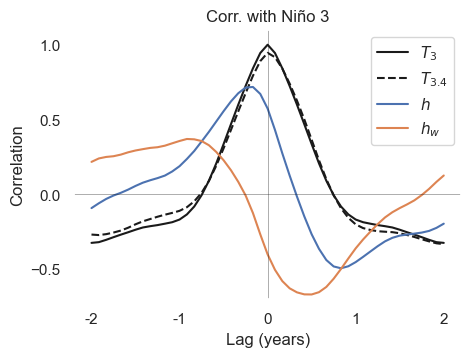

In [5]:
## compute cross-corr
xcorr = src.XRO.xcorr(idx_anom, idx_anom["T_3"], maxlags=24)

## plot result
fig, ax = plt.subplots(figsize=(5, 3.5))

## plot data
ax.plot(xcorr.lag, xcorr["T_3"], label=r"$T_3$", c="k")
ax.plot(xcorr.lag, xcorr["T_34"], label=r"$T_{3.4}$", c="k", ls="--")
ax.plot(xcorr.lag, xcorr["h"], label=r"$h$")
ax.plot(xcorr.lag, xcorr["h_w"], label=r"$h_w$")

## format plot
ax.set_title("Corr. with Niño 3")
ax.legend()
format_xcorr_ax(ax)

plt.show()

## Fit RO models

In [6]:
## specify order of annual cycle, mask parameters
ac_order = 3
ac_mask_idx = [(1, 1)]  # epsilon
# ac_mask_idx = [(1,0), (1, 1)] # epsilon and F2
# ac_mask_idx = [(0,1),(1,0),(1, 1)] # all except R
# ac_mask_idx = None

## initialize model
model = src.XRO.XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## get fit for reanalysis
fit_h = model.fit_matrix(idx_anom[["T_34", "h"]], ac_mask_idx=ac_mask_idx)
fit_hw = model.fit_matrix(idx_anom[["T_3", "h_w"]], ac_mask_idx=ac_mask_idx)

## extract params
p_h = model.get_RO_parameters(fit_h)
p_hw = model.get_RO_parameters(fit_hw)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


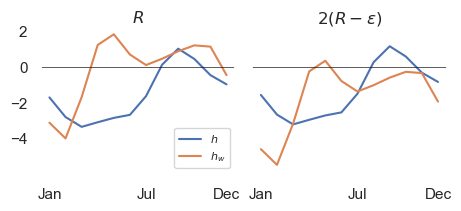

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(4.5, 2), layout="constrained")

for i, (ax, n) in enumerate(zip(axs, ["R", "BJ_ac"])):
    ax.plot(p_h.cycle, p_h[n], label=r"$h$")
    ax.plot(p_hw.cycle, p_hw[n], label=r"$h_w$")

    ## format
    ax.axhline(0, ls="-", c="k", lw=0.5)
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])

## label
axs[1].set_yticks([])
axs[0].set_yticks([-4, -2, 0, 2])
axs[0].set_title(r"$R$")
axs[1].set_title(r"$2\left(R-\varepsilon\right)$")
axs[0].legend(prop=dict(size=8))
axs[0].set_ylim([-6, 2])
axs[1].set_ylim(0.5 * np.array(axs[0].get_ylim()))

plt.show()

## diagnostics

In [8]:
## specify grid for plotting
zz = np.linspace(-3, 3)
xx, yy = np.meshgrid(zz, zz)

## funcs to get dTdt and dhdt
# get_t_idx = lambda x, m = x.isel(time= (x.time.dt.month==m))
dTdt = (
    lambda p, m, T, h: p["R"].sel(cycle=m).values * T + p["F1"].sel(cycle=m).values * h
)
dhdt = (
    lambda p, m, T, h: -p["F2"].sel(cycle=m).values * T
    - p["epsilon"].sel(cycle=m).values * h
)

dTdt_grid = lambda p, m: dTdt(p, m, T=xx, h=yy)
dhdt_grid = lambda p, m: dhdt(p, m, T=xx, h=yy)


def get_dxdt_hat(x_xr, fit=None):
    """get estimated dxdt given data"""

    ## convert x from xarray to numpy
    x = x_xr.to_dataarray().rename({"variable": "rankx"})
    x["rankx"] = [1, 2]

    ## get fits in correct format for broadcasting
    L = copy.deepcopy(fit["Lac"]).rename({"cycle": "month"})
    L["month"] = np.arange(1, 13)

    ## get tendency
    dxdt = (L * x.groupby("time.month")).sum("rankx")

    return dxdt


## func to plot data on ax object
def plot_tend(ax, p, m, lev, show_h=False):
    """plot tendency on given ax object"""

    ax.set_aspect("equal")
    cp = ax.contourf(xx, yy, dTdt_grid(p=p, m=m), cmap="cmo.balance", levels=lev)

    if show_h:
        cs = ax.contour(xx, yy, dhdt_grid(p=p, m=m), colors="k", levels=lev)

    return cp


def plot_tend_actual(ax, x, fit, m, amp):
    """plot actual tendency"""

    ## get times to select
    t_idx = dict(time=(x.time.dt.month == m))

    ## compute tendency
    dxdt = src.XRO.gradient(src.XRO._convert_to_numpy(x))
    dxdt = dxdt[:, t_idx["time"].values]

    ## convert data from dataset to dataarray
    x_da = x.to_dataarray()

    ## get normalized colorbar
    norm = mpl.colors.Normalize(vmin=-amp, vmax=amp)

    ## scatter the data
    ax.scatter(
        x_da.isel(variable=0, **t_idx),
        x_da.isel(variable=1, **t_idx),
        s=40,
        c=dxdt[0],
        norm=norm,
        cmap="cmo.balance",
        edgecolors="k",
    )

    return

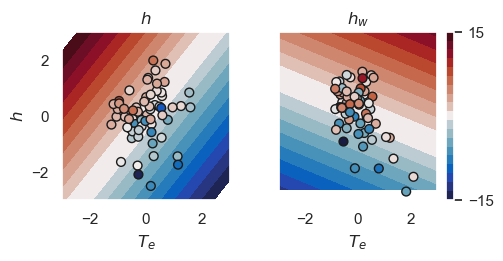

In [9]:
## specify which month to plot
month = 4

## get amplitude for plot
amp = 15

## get time index
t_idx = dict(time=idx.time.dt.month == month)

## evaluate time derivative
# dxdt = get_dxdt(idx_anom[["T_34","h"]], fit=fit_h).isel(t_idx)

## kwargs for scatter
scatter_kwargs = dict(m=month, amp=amp)

## specify contour levels
lev = src.utils.make_cb_range(amp, amp / 10)

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), layout="constrained")

## plot first
cp = plot_tend(axs[0], p=p_h, m=month, lev=lev)
plot_tend_actual(ax=axs[0], x=idx_anom[["T_34", "h"]], fit=fit_h, **scatter_kwargs)

## plot second
cp2 = plot_tend(axs[1], p=p_hw, m=month, lev=lev)
plot_tend_actual(ax=axs[1], x=idx_anom[["T_3", "h_w"]], fit=fit_hw, **scatter_kwargs)

## label
cb = fig.colorbar(cp2, ticks=[lev.min(), lev.max()])
axs[1].set_yticks([])
axs[0].set_ylabel(r"$h$")
axs[0].set_title("$h$")
axs[1].set_title("$h_w$")

for ax in axs:
    ax.set_xlabel(r"$T_e$")

plt.show()

### Scatter plots

In [10]:
## compute gradients
grads = src.XRO.gradient(src.XRO._convert_to_numpy(idx_anom))

## add to array
for i, n in enumerate(list(idx_anom)):
    idx_anom.update(
        {f"{n}_grad": xr.DataArray(grads[i], coords=dict(time=idx_anom.time))}
    )


def get_stats(T_var, h_var, month):
    """Get statistics needed to compute R"""

    ## indexer
    t_idx = dict(time=idx.time.dt.month == month)

    ## get subset of array
    sel_vars = [T_var, h_var, f"{T_var}_grad", f"{h_var}_grad"]
    names = {
        T_var: "T",
        h_var: "h",
        f"{T_var}_grad": "T_grad",
        f"{h_var}_grad": "h_grad",
    }
    X = idx_anom.isel(t_idx)[sel_vars].rename(names)

    ## compute stats
    sigma_T = np.std(X["T"].values)
    sigma_h = np.std(X["h"].values)
    r = scipy.stats.pearsonr(X["T"].values, X["h"].values)[0]

    ## compute covariance
    TtT = np.mean(X["T_grad"] * X["T"]).values.item() * np.pow(sigma_T, -2)
    Tth = (
        np.mean(X["T_grad"] * X["h"]).values.item()
        * np.pow(sigma_T, -1)
        * np.pow(sigma_h, -1)
    )

    return dict(r=r, TtT=TtT, Tth=Tth)


def get_R(T_var, h_var, month):
    """function to compute estimate of R for given variables and month"""

    ## compute stats
    stats = get_stats(T_var=T_var, h_var=h_var, month=month)
    r = stats["r"]
    TtT = stats["TtT"]
    Tth = stats["Tth"]

    ## compute estimate for R
    Rhat = 1 / (1 - r**2) * (TtT - r * Tth)

    return Rhat

\begin{align}
    R &= \frac{\sigma_T^{-1}}{1-r^2}\left[\left<T_t,\tilde{T}\right> - r\left<T_t,\tilde{h}\right>\right]
\end{align}

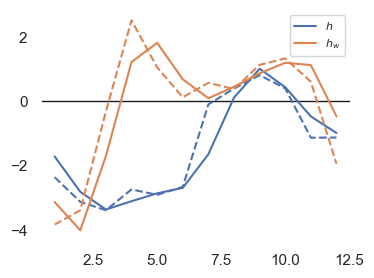

In [11]:
#### compute
## kwargs
kwargs_h = dict(T_var="T_34", h_var="h")
kwargs_hw = dict(T_var="T_3", h_var="h_w")

## compute estimates
Rhats_h = np.array([get_R(month=m, **kwargs_h) for m in np.arange(1, 13)])
Rhats_hw = np.array([get_R(month=m, **kwargs_hw) for m in np.arange(1, 13)])


#### plot
colors = sns.color_palette()
fig, ax = plt.subplots(figsize=(4, 3))

## plot first version
ax.plot(p_h.cycle, Rhats_h, c=colors[0], ls="--")
ax.plot(p_h.cycle, p_h["R"], c=colors[0], label=r"$h$")

## plot second version
ax.plot(p_h.cycle, Rhats_hw, c=colors[1], ls="--")
ax.plot(p_h.cycle, p_hw["R"], c=colors[1], label=r"$h_w$")

## label
ax.legend(prop=dict(size=8))
ax.axhline(0, lw=1, c="k", zorder=0.5)

plt.show()

Look at relationship between $T_e$ and $\overline{h}-h_w$

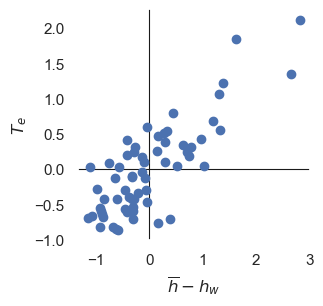

In [12]:
m = 4
t_idx = dict(time=idx.time.dt.month == m)

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(
    idx_anom["h"].isel(t_idx) - idx_anom["h_w"].isel(t_idx),
    idx_anom["T_3"].isel(t_idx),
    # -idx_anom["h_w"].isel(t_idx), idx_anom["T_3"].isel(t_idx)
)


## label
ax.set_xlabel(r"$\overline{h}-h_w$")
ax.set_ylabel(r"$T_e$")
kwargs = dict(c="k", lw=0.8, zorder=0.5)
ax.axvline(0, **kwargs)
ax.axhline(0, **kwargs)
plt.show()